<a href="https://colab.research.google.com/github/pratishta/2048_GWC/blob/master/spatial_summary_geospatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install pysal

In [ ]:
!pip install mapclassify

In [ ]:
!pip install geopandas

In [ ]:
!pip install splot

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import pysal
import mapclassify
import requests
import numpy as np
from zipfile import ZipFile

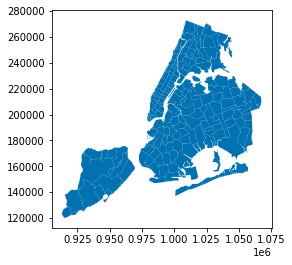

In [ ]:
nyc = gpd.read_file("MODZCTA_2010.shp")
nyc.plot();

In [ ]:
nyc.crs

<Projected CRS: PROJCS["Lambert_Conformal_Conic",GEOGCS["NAD83",DA ...>
Name: Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# really should combine the shapefile in GEODA or something or maybe even here through pandas before doing the weights analysis
nyc.rename(columns={"MODZCTA": "modzcta"}, inplace=True)
nyc.head()

,modzcta,label,geometry
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21..."
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19..."
2,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20..."
3,10004,10004,"MULTIPOLYGON (((982030.000 197212.000, 981958...."
4,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19..."


In [ ]:
import libpysal
w = libpysal.weights.Queen.from_dataframe(nyc)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 37.
  warnings.warn(message)


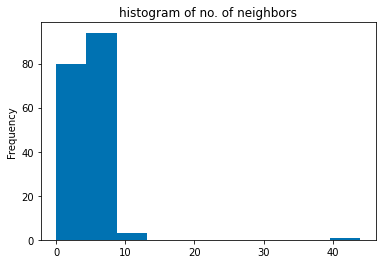

In [ ]:
cardinalities = pd.Series(w.cardinalities)
cardinalities.plot(kind='hist', title='histogram of no. of neighbors');

In [ ]:
nyc['modzcta']=nyc['modzcta'].astype(int)
nyc.dtypes

modzcta        int64
label         object
geometry    geometry
dtype: object

In [ ]:
# getting the coronavirus data
covid_data = pd.read_csv('data-by-modzcta-040521.csv')
covid_data.rename(columns={"MODIFIED_ZCTA": "modzcta"}, inplace=True)
covid_data.head()

,modzcta,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label,lat,lon,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,1447,5240.27,27613.09,32,115.89,7.68,19303
1,10002,Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,5515,7321.83,75322.71,253,335.89,12.25,46247
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,2623,4859.40,53977.81,47,87.07,6.64,40171
3,10004,Financial District,Manhattan,10004,40.703675,-74.013106,238,8007.76,2972.12,2,67.29,6.79,3533
4,10005,Financial District,Manhattan,10005,40.706092,-74.008861,383,4373.53,8757.23,0,0.00,6.43,5910


In [ ]:

c = pd.DataFrame(covid_data.columns)
c.to_csv('covid_cols.csv')

In [ ]:
restaurant_data = pd.read_csv('Open_Restaurant_Applications.csv')

restaurant_data.head()

,objectid,globalid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Legal Business Name,Doing Business As (DBA),Building Number,Street,Borough,Postcode,Business Address,Food Service Establishment Permit #,Sidewalk Dimensions (Length),Sidewalk Dimensions (Width),Sidewalk Dimensions (Area),Roadway Dimensions (Length),Roadway Dimensions (Width),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA Serial Number,SLA License Type,Landmark District or Building,landmarkDistrict_terms,healthCompliance_terms,Time of Submission,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,32,ae5914d4-6080-4144-8634-98ca22b215de,sidewalk,Arbuz Cafe,Arbuz Cafe NY inc.,Arbuz Cafe NY inc.,1706,Sheepshead Bay Rd,Brooklyn,11235,"1706 Sheepshead Bay Rd, Brooklyn, NY",50047431,14.0,14.0,196.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 10:37:00 AM,40.585724,-73.951767,15.0,48.0,606.0,3343289.0,3.087700e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach
1,395,adb6a57c-586b-4833-8134-f3a921e71ab1,both,Short Stories,"355 Restaurant Group, LLC",Short Stories,355,Bowery,Manhattan,10003,"355 Bowery, Manhattan, NY",50088628,70.0,12.0,840.0,40.0,8.0,320.0,yes,yes,yes,1312424,OP,no,NaN,yes,06/19/2020 10:39:00 AM,40.726736,-73.991662,3.0,2.0,38.0,1079833.0,1.004590e+09,East Village
2,33,81a2bad2-5bdc-49ed-8bb6-9dc3f9798732,roadway,Nerai,Koureli Restaurant Group Inc,Nerai,55,East 54th Street,Manhattan,10022,"55 East 54th Street, Manhattan, NY",41720892,NaN,NaN,NaN,25.0,7.0,175.0,no,yes,yes,1256972,OP,no,NaN,yes,06/19/2020 10:41:00 AM,40.760117,-73.973162,5.0,4.0,102.0,1035748.0,1.012900e+09,Midtown-Midtown South
3,34,b4bcb3a5-e2f7-4069-8c3b-21f47f051a63,roadway,Hill Country,"Hill Country New York, LLC",Hill Country,30,West 26th,Manhattan,10010,"30 West 26th, Manhattan, NY",41240424,NaN,NaN,NaN,55.0,10.0,550.0,no,yes,yes,1182279,OP,no,NaN,yes,06/19/2020 10:42:00 AM,40.744102,-73.989762,5.0,3.0,58.0,1015629.0,1.008270e+09,Hudson Yards-Chelsea-Flatiron-Union Square
4,465,130e7b58-0bbe-4c30-8dbd-186a3c467634,sidewalk,The Beatrice Inn,Butcher's Block Hospitality,The Beatrice Inn,285,West 12th Street,Manhattan,10014,"285 West 12th Street, Manhattan, NY",50048588,30.0,16.0,480.0,NaN,NaN,NaN,yes,no,yes,1291690,OP,yes,yes,yes,06/19/2020 10:45:00 AM,40.737553,-74.004121,2.0,3.0,77.0,1011452.0,1.006250e+09,West Village


In [ ]:
r = pd.DataFrame(restaurant_data.columns)
r.to_csv('restaurant_cols.csv')

In [ ]:
r


,0
0,objectid
1,globalid
2,Seating Interest (Sidewalk/Roadway/Both)
3,Restaurant Name
4,Legal Business Name
5,Doing Business As (DBA)
6,Building Number
7,Street
8,Borough
9,Postcode


In [ ]:
# convert open restaurant data into geodataframe

# print(restaurant_data.crs)

restaurant_geodf = gpd.GeoDataFrame(
   restaurant_data, geometry=gpd.points_from_xy(restaurant_data.Longitude, restaurant_data.Latitude))

restaurant_geodf.head()

,objectid,globalid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Legal Business Name,Doing Business As (DBA),Building Number,Street,Borough,Postcode,Business Address,Food Service Establishment Permit #,Sidewalk Dimensions (Length),Sidewalk Dimensions (Width),Sidewalk Dimensions (Area),Roadway Dimensions (Length),Roadway Dimensions (Width),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA Serial Number,SLA License Type,Landmark District or Building,landmarkDistrict_terms,healthCompliance_terms,Time of Submission,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry
0,32,ae5914d4-6080-4144-8634-98ca22b215de,sidewalk,Arbuz Cafe,Arbuz Cafe NY inc.,Arbuz Cafe NY inc.,1706,Sheepshead Bay Rd,Brooklyn,11235,"1706 Sheepshead Bay Rd, Brooklyn, NY",50047431,14.0,14.0,196.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 10:37:00 AM,40.585724,-73.951767,15.0,48.0,606.0,3343289.0,3.087700e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.95177 40.58572)
1,395,adb6a57c-586b-4833-8134-f3a921e71ab1,both,Short Stories,"355 Restaurant Group, LLC",Short Stories,355,Bowery,Manhattan,10003,"355 Bowery, Manhattan, NY",50088628,70.0,12.0,840.0,40.0,8.0,320.0,yes,yes,yes,1312424,OP,no,NaN,yes,06/19/2020 10:39:00 AM,40.726736,-73.991662,3.0,2.0,38.0,1079833.0,1.004590e+09,East Village,POINT (-73.99166 40.72674)
2,33,81a2bad2-5bdc-49ed-8bb6-9dc3f9798732,roadway,Nerai,Koureli Restaurant Group Inc,Nerai,55,East 54th Street,Manhattan,10022,"55 East 54th Street, Manhattan, NY",41720892,NaN,NaN,NaN,25.0,7.0,175.0,no,yes,yes,1256972,OP,no,NaN,yes,06/19/2020 10:41:00 AM,40.760117,-73.973162,5.0,4.0,102.0,1035748.0,1.012900e+09,Midtown-Midtown South,POINT (-73.97316 40.76012)
3,34,b4bcb3a5-e2f7-4069-8c3b-21f47f051a63,roadway,Hill Country,"Hill Country New York, LLC",Hill Country,30,West 26th,Manhattan,10010,"30 West 26th, Manhattan, NY",41240424,NaN,NaN,NaN,55.0,10.0,550.0,no,yes,yes,1182279,OP,no,NaN,yes,06/19/2020 10:42:00 AM,40.744102,-73.989762,5.0,3.0,58.0,1015629.0,1.008270e+09,Hudson Yards-Chelsea-Flatiron-Union Square,POINT (-73.98976 40.74410)
4,465,130e7b58-0bbe-4c30-8dbd-186a3c467634,sidewalk,The Beatrice Inn,Butcher's Block Hospitality,The Beatrice Inn,285,West 12th Street,Manhattan,10014,"285 West 12th Street, Manhattan, NY",50048588,30.0,16.0,480.0,NaN,NaN,NaN,yes,no,yes,1291690,OP,yes,yes,yes,06/19/2020 10:45:00 AM,40.737553,-74.004121,2.0,3.0,77.0,1011452.0,1.006250e+09,West Village,POINT (-74.00412 40.73755)


In [ ]:
covid_geodata = nyc.merge(covid_data, on='modzcta', how='left')

In [ ]:
covid_geodata.head()

,modzcta,label_x,geometry,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label_y,lat,lon,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS
0,10001,"10001, 10118","POLYGON ((987646.000 210360.000, 987522.000 21...",Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,1447.0,5240.27,27613.09,32.0,115.89,7.68,19303.0
1,10002,10002,"POLYGON ((985342.000 197658.000, 985336.000 19...",Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,5515.0,7321.83,75322.71,253.0,335.89,12.25,46247.0
2,10003,10003,"POLYGON ((987412.000 202684.000, 987400.000 20...",East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,2623.0,4859.40,53977.81,47.0,87.07,6.64,40171.0
3,10004,10004,"MULTIPOLYGON (((982030.000 197212.000, 981958....",Financial District,Manhattan,10004,40.703675,-74.013106,238.0,8007.76,2972.12,2.0,67.29,6.79,3533.0
4,10005,10005,"POLYGON ((982126.000 195468.000, 982080.000 19...",Financial District,Manhattan,10005,40.706092,-74.008861,383.0,4373.53,8757.23,0.0,0.00,6.43,5910.0


In [ ]:
# set both crs to the same projection (changecovid geodata slightly bc i don't know what the fuck kind of projection it was befor
# but maybe when i find out, i can actually change the restaurant crs to the same thing)
covid_geodata = covid_geodata.to_crs("EPSG:4326")
nyc = nyc.to_crs("EPSG:4326")
restaurant_geodf = restaurant_geodf.set_crs("EPSG:4326")

In [ ]:
restaurant_geo = gpd.sjoin(restaurant_geodf, nyc, how="inner", op='intersects')
restaurant_geo.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


,objectid,globalid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Legal Business Name,Doing Business As (DBA),Building Number,Street,Borough,Postcode,Business Address,Food Service Establishment Permit #,Sidewalk Dimensions (Length),Sidewalk Dimensions (Width),Sidewalk Dimensions (Area),Roadway Dimensions (Length),Roadway Dimensions (Width),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA Serial Number,SLA License Type,Landmark District or Building,landmarkDistrict_terms,healthCompliance_terms,Time of Submission,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry,index_right,modzcta,label
0,32,ae5914d4-6080-4144-8634-98ca22b215de,sidewalk,Arbuz Cafe,Arbuz Cafe NY inc.,Arbuz Cafe NY inc.,1706,Sheepshead Bay Rd,Brooklyn,11235,"1706 Sheepshead Bay Rd, Brooklyn, NY",50047431,14.0,14.0,196.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 10:37:00 AM,40.585724,-73.951767,15.0,48.0,606.0,3343289.0,3.087700e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.95177 40.58572),121,11235,11235
147,148,fa83a87e-682a-4685-8952-b9f77f00cefc,sidewalk,Bassett Pickle Works Inc,Bassett Pickle Works Inc.,Bassett PBassett Caterers,1404,Avenue X,Brooklyn,11235,"1404 Avenue X, Brooklyn, NY",40597923,54.0,4.0,216.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 11:19:00 AM,40.592113,-73.955907,15.0,48.0,590.0,3202966.0,3.074160e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.95591 40.59211),121,11235,11235
229,254,74e3c11c-0958-43b3-8694-f8960168187d,sidewalk,718 Bistro,718 Bistro Inc.,718 Bistro Inc.,350,Neptune Ave,Brooklyn,11235,"350 Neptune Ave, Brooklyn, NY",50079429,65.0,8.0,520.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 11:38:00 AM,40.580750,-73.965609,13.0,48.0,364.0,3424564.0,3.086620e+09,Brighton Beach,POINT (-73.96561 40.58075),121,11235,11235
448,413,4cb3fa3b-20b7-4895-8116-17797de22232,both,Wheeler's,1705 wheeler's Ltd,Wheeler's,1705,sheepshead bay road,Brooklyn,11235,"1705 sheepshead bay road, Brooklyn, NY",40400209,14.0,26.0,364.0,6.0,26.0,156.0,yes,yes,yes,1012522,OP,no,NaN,yes,06/19/2020 12:33:00 PM,40.585751,-73.951756,15.0,48.0,600.0,3247050.0,3.087720e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.95176 40.58575),121,11235,11235
449,531,32cea974-b470-4148-8f03-8633eb147980,sidewalk,2255 Emmons Cafe Lounge,2255 Emmons Cafe Lounge,Opera Cafe Lounge,2255,Emmons Avenue,Brooklyn,11235,"2255 Emmons Avenue, Brooklyn, NY",41658283,100.0,40.0,4000.0,NaN,NaN,NaN,yes,no,yes,1261974,RW,no,NaN,yes,06/19/2020 12:34:00 PM,40.583690,-73.944691,15.0,48.0,608.0,3342943.0,3.087830e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.94469 40.58369),121,11235,11235


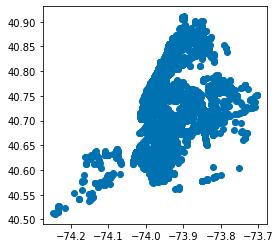

In [ ]:
restaurant_geo.plot()

In [ ]:
restaurant_geo.describe()

,objectid,Postcode,Sidewalk Dimensions (Length),Sidewalk Dimensions (Width),Sidewalk Dimensions (Area),Roadway Dimensions (Length),Roadway Dimensions (Width),Roadway Dimensions (Area),Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,index_right,modzcta
count,10269.000000,10269.000000,8777.000000,8777.000000,8777.000000,6547.000000,6547.000000,6547.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,1.019300e+04,1.019300e+04,10269.000000,10269.000000
mean,5854.844289,10612.078976,33.422582,10.340435,387.428962,31.070872,8.325951,267.600733,40.733098,-73.952221,5.243062,17.611549,3066.689648,2.305097e+06,2.250565e+09,63.778752,10611.469861
std,3381.330577,602.995295,35.260322,7.023246,1016.019175,28.453432,3.708036,457.230878,0.057144,0.061141,3.666743,15.264227,13206.824495,1.323312e+06,1.288614e+09,51.367465,602.633863
min,32.000000,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.511019,-74.248014,1.000000,1.000000,1.000000,1.000000e+06,1.000048e+09,0.000000,10001.000000
25%,2909.000000,10016.000000,16.000000,6.000000,112.000000,17.000000,8.000000,128.000000,40.706657,-73.990296,2.000000,3.000000,70.000000,1.025403e+06,1.008500e+09,13.000000,10016.000000
50%,5865.000000,10454.000000,24.000000,8.000000,217.000000,24.000000,8.000000,192.000000,40.734598,-73.968681,5.000000,14.000000,154.000000,2.016447e+06,2.031050e+09,59.000000,10454.000000
75%,8795.000000,11221.000000,40.000000,14.000000,400.000000,36.000000,8.000000,300.500000,40.761944,-73.921814,7.000000,33.000000,485.000000,3.328762e+06,3.061370e+09,107.000000,11220.000000
max,11631.000000,11697.000000,1000.000000,50.000000,50000.000000,1000.000000,50.000000,25000.000000,40.911190,-73.702668,81.000000,51.000000,157903.000000,5.169029e+06,5.080430e+09,176.000000,11697.000000


In [ ]:
sideroad_df = restaurant_geo[(restaurant_geo['Approved for Sidewalk Seating'] == "yes") | (restaurant_geo['Approved for Roadway Seating'] == "yes")]
sideroad_df.head(1)
# roadway_yes = restaurant_geo[(restaurant_geo['Approved for Roadway Seating'] == "yes")]


,objectid,globalid,Seating Interest (Sidewalk/Roadway/Both),Restaurant Name,Legal Business Name,Doing Business As (DBA),Building Number,Street,Borough,Postcode,Business Address,Food Service Establishment Permit #,Sidewalk Dimensions (Length),Sidewalk Dimensions (Width),Sidewalk Dimensions (Area),Roadway Dimensions (Length),Roadway Dimensions (Width),Roadway Dimensions (Area),Approved for Sidewalk Seating,Approved for Roadway Seating,Qualify Alcohol,SLA Serial Number,SLA License Type,Landmark District or Building,landmarkDistrict_terms,healthCompliance_terms,Time of Submission,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,geometry,index_right,modzcta,label
0,32,ae5914d4-6080-4144-8634-98ca22b215de,sidewalk,Arbuz Cafe,Arbuz Cafe NY inc.,Arbuz Cafe NY inc.,1706,Sheepshead Bay Rd,Brooklyn,11235,"1706 Sheepshead Bay Rd, Brooklyn, NY",50047431,14.0,14.0,196.0,NaN,NaN,NaN,yes,no,no,NaN,NaN,no,NaN,yes,06/19/2020 10:37:00 AM,40.585724,-73.951767,15.0,48.0,606.0,3343289.0,3.087700e+09,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,POINT (-73.95177 40.58572),121,11235,11235


In [ ]:
restaurant_count = sideroad_df.groupby(['modzcta']).count()
restaurant_count = restaurant_count.loc[:, restaurant_count.columns.intersection(['modzcta', 'objectid'])]
restaurant_count.rename(columns={"objectid": "open_restaurant_count"}, inplace=True)
restaurant_count.head()

,open_restaurant_count
modzcta,
10001,167
10002,225
10003,412
10004,39
10005,25


In [ ]:
restaurant_count.describe()

,open_restaurant_count
count,174.000000
mean,57.160920
std,71.566433
min,1.000000
25%,10.250000
50%,27.500000
75%,81.500000
max,412.000000


In [ ]:
# covid-restaurant geo-dataframe
cr_gdf = covid_geodata.merge(restaurant_count, on='modzcta')
cr_gdf.head(20)

,modzcta,label_x,geometry,NEIGHBORHOOD_NAME,BOROUGH_GROUP,label_y,lat,lon,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE,TOTAL_COVID_TESTS,open_restaurant_count
0,10001,"10001, 10118","POLYGON ((-73.98774 40.74407, -73.98819 40.743...",Chelsea/NoMad/West Chelsea,Manhattan,"10001, 10118",40.750693,-73.997137,1447.0,5240.27,27613.09,32.0,115.89,7.68,19303.0,167
1,10002,10002,"POLYGON ((-73.99606 40.70920, -73.99608 40.709...",Chinatown/Lower East Side,Manhattan,10002,40.715781,-73.986176,5515.0,7321.83,75322.71,253.0,335.89,12.25,46247.0,225
2,10003,10003,"POLYGON ((-73.98859 40.72300, -73.98864 40.722...",East Village/Gramercy/Greenwich Village,Manhattan,10003,40.731825,-73.989164,2623.0,4859.40,53977.81,47.0,87.07,6.64,40171.0,412
3,10004,10004,"MULTIPOLYGON (((-74.00801 40.70798, -74.00827 ...",Financial District,Manhattan,10004,40.703675,-74.013106,238.0,8007.76,2972.12,2.0,67.29,6.79,3533.0,39
4,10005,10005,"POLYGON ((-74.00766 40.70319, -74.00783 40.703...",Financial District,Manhattan,10005,40.706092,-74.008861,383.0,4373.53,8757.23,0.0,0.00,6.43,5910.0,25
5,10006,10006,"POLYGON ((-74.01251 40.70677, -74.01325 40.705...",Financial District,Manhattan,10006,40.709651,-74.013044,156.0,4612.93,3381.80,1.0,29.57,6.71,2369.0,15
6,10007,10007,"POLYGON ((-74.00397 40.71182, -74.00405 40.711...",TriBeCa,Manhattan,10007,40.713923,-74.007546,361.0,5163.45,6991.45,4.0,57.21,5.92,6162.0,32
7,10009,10009,"POLYGON ((-73.97872 40.71998, -73.97875 40.719...",Alphabet City/East Village/Stuyvesant Town-Coo...,Manhattan,10009,40.726380,-73.978704,3369.0,5894.90,57151.12,113.0,197.72,9.10,37655.0,227
8,10010,10010,"POLYGON ((-73.97441 40.73259, -73.97449 40.732...",Flatiron/Gramercy/Kips Bay,Manhattan,10010,40.739119,-73.982544,1602.0,4803.17,33353.00,37.0,110.93,6.01,26944.0,123
9,10011,10011,"POLYGON ((-74.00821 40.74215, -74.00870 40.742...",Chelsea,Manhattan,10011,40.741707,-74.000062,2424.0,4872.76,49745.99,62.0,124.63,7.10,34571.0,253


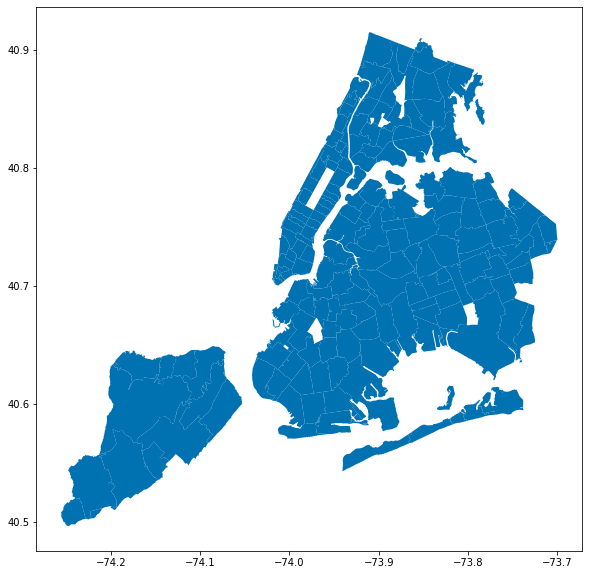

In [ ]:
cr_gdf.plot(figsize=(10, 10))

In [ ]:
cr_gdf['open_restaurant_count'].describe()

count    174.000000
mean      57.160920
std       71.566433
min        1.000000
25%       10.250000
50%       27.500000
75%       81.500000
max      412.000000
Name: open_restaurant_count, dtype: float64

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

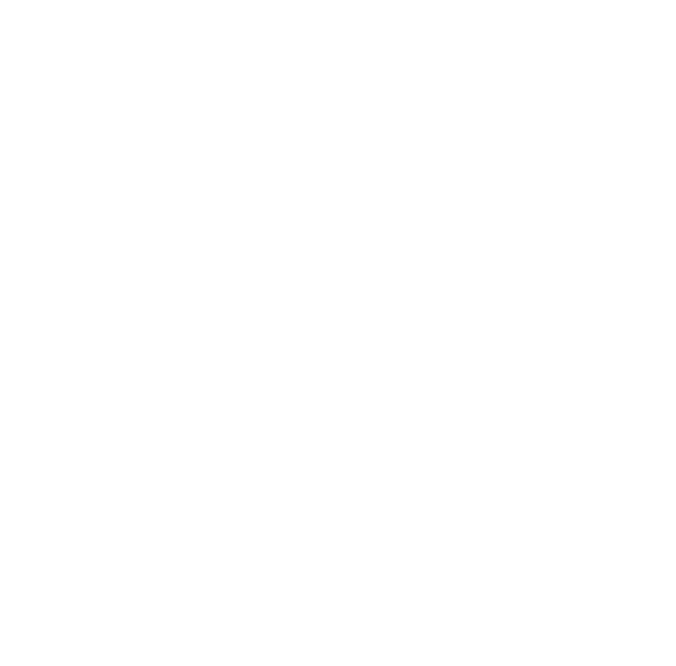

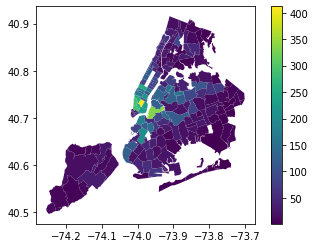

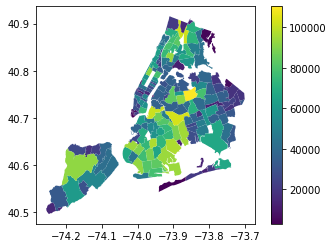

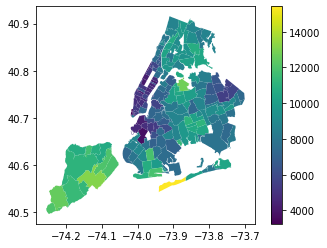

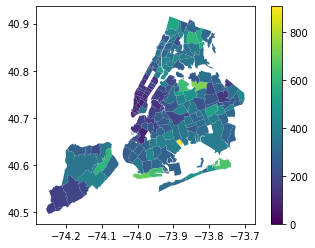

In [ ]:
# DESCRIPTIVE STATS MAPS

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
cr_gdf.plot(legend=True, column='open_restaurant_count')
ax.set_aspect('equal')
ax.set_axis_off()

#                     # Subplot 2 #
ax = axs[1]
cr_gdf.plot(legend=True, column='POP_DENOMINATOR')
ax.set_aspect('equal')
ax.set_axis_off()

#                     # Subplot 3 #
ax = axs[2]
cr_gdf.plot(legend=True, column='COVID_CASE_RATE')
ax.set_aspect('equal')
ax.set_axis_off()

#                     # Subplot 4 #
ax = axs[3]
cr_gdf.plot(legend=True, column='COVID_DEATH_RATE')
ax.set_aspect('equal')
ax.set_axis_off()


# Display the figure
# plt.show()

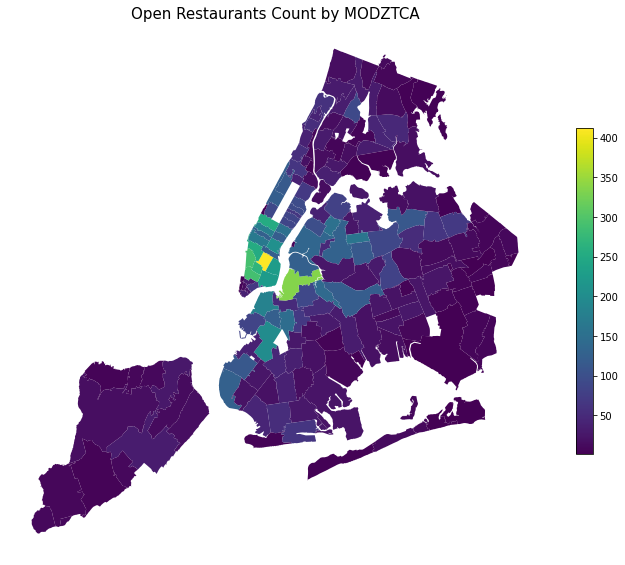

In [ ]:
# cr_gdf.plot(figsize=(10, 10), column='open_restaurant_count', legend=True)

# or_ds.axes.get_xaxis().set_visible(False)
# or_ds.axes.get_yaxis().set_visible(False)

# cr_gdf['log_restaurant_count'] = np.log10(cr_gdf['open_restaurant_count'])
op_dr = cr_gdf.plot(figsize=(12, 12), legend=True, column='open_restaurant_count', legend_kwds={'shrink': 0.5})
op_dr.axis("off")
op_dr.set_title('Open Restaurants Count by MODZTCA', fontdict={'fontsize': '15', 'fontweight' : '3'})



plt.show()

Text(0.5, 1.0, 'Population Denominator by MODZTCA')

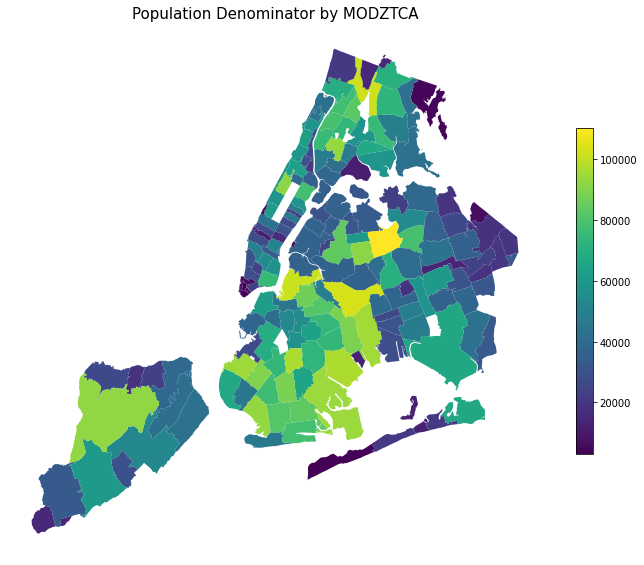

In [ ]:
pop_ds = cr_gdf.plot(figsize=(12, 12), legend=True, legend_kwds={'shrink': 0.5}, column='POP_DENOMINATOR')
pop_ds.axis("off")
pop_ds.set_title('Population Denominator by MODZTCA', fontdict={'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'COVID-19 Case Rate by MODZTCA')

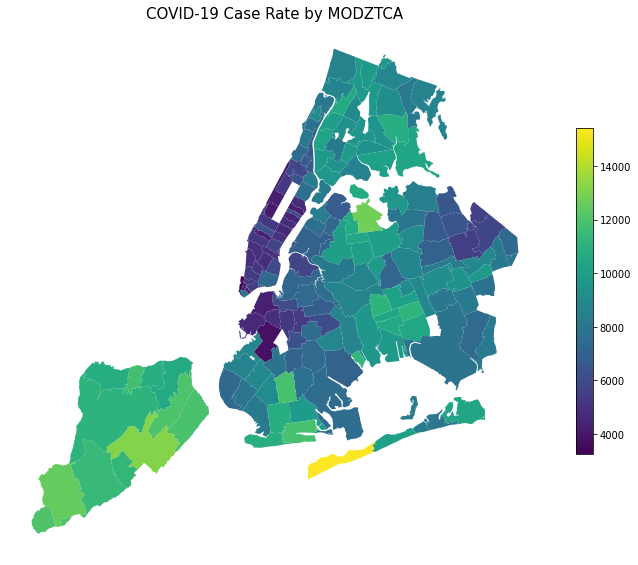

In [ ]:
case_r_ds = cr_gdf.plot(figsize=(12, 12), legend=True, legend_kwds={'shrink': 0.5}, column='COVID_CASE_RATE')
case_r_ds.axis("off")
case_r_ds.set_title('COVID-19 Case Rate by MODZTCA', fontdict={'fontsize': '15', 'fontweight' : '3'})

Text(0.5, 1.0, 'COVID-19 Death Rate by MODZTCA')

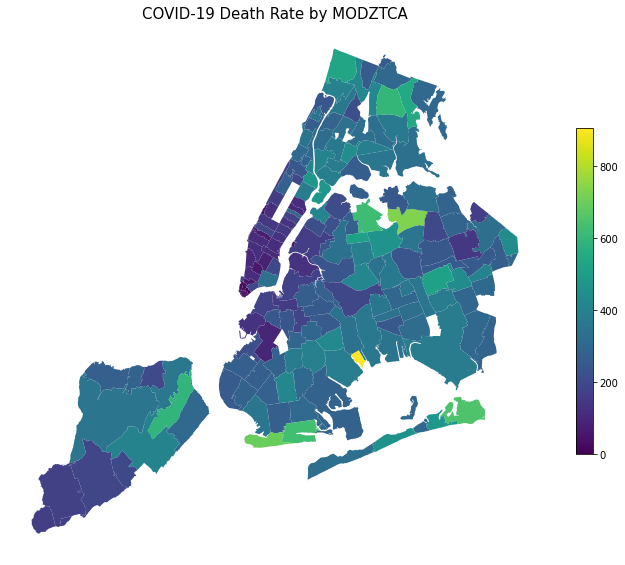

In [ ]:
dr_ds = cr_gdf.plot(figsize=(12, 12), legend=True, legend_kwds={'shrink': 0.5},column='COVID_DEATH_RATE')
dr_ds.axis("off")
dr_ds.set_title('COVID-19 Death Rate by MODZTCA', fontdict={'fontsize': '15', 'fontweight' : '3'})

In [ ]:
cr_gdf[['open_restaurant_count', 'POP_DENOMINATOR', 'COVID_CASE_RATE', 'COVID_DEATH_RATE']].describe().to_csv("descriptive_stats.csv")

In [ ]:
import libpysal
w = libpysal.weights.Queen.from_dataframe(cr_gdf)

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


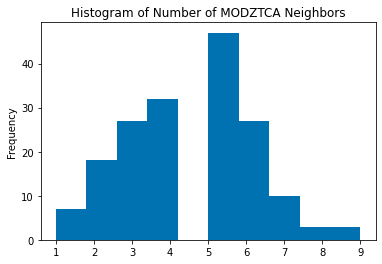

In [ ]:
cardinalities = pd.Series(w.cardinalities)
cardinalities.plot(kind='hist', title='Histogram of Number of MODZTCA Neighbors');

In [ ]:
from esda.moran import (Moran, Moran_Local)


In [ ]:
mi = Moran(cr_gdf['COVID_CASE_RATE'], w)

In [ ]:
mi.I

0.7605526754798292

In [ ]:
mi.p_sim

0.001

In [ ]:
mi = Moran(cr_gdf['COVID_DEATH_RATE'], w)
print(mi.I)
mi.p_sim

0.47408235260605647


0.001

In [ ]:
import spreg

In [ ]:
# weighted OLS regression for covid case rates
target='COVID_CASE_RATE'
features=["open_restaurant_count"]

Y = cr_gdf[target].values.reshape(len(cr_gdf),1) #add dimension for spreg OLS DV
X = cr_gdf[features].values

In [ ]:
Y.shape,cr_gdf[target].shape

((174, 1), (174,))

In [ ]:
# with weights
ols=spreg.OLS(Y, X, w=w, \
                          name_y="COVID_CASE_RATE", name_x=["open_restaurant_count"],name_w="queen's continuity", \
                          nonspat_diag=True, #print stats
                          spat_diag=True,  #print Lagrange multiplier tests
                          moran=True)  # compute Moran’s I on the residuals
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :queen's continuity
Dependent Variable  :COVID_CASE_RATE                Number of Observations:         174
Mean dependent var  :   8085.6014                Number of Variables   :           2
S.D. dependent var  :   2298.5683                Degrees of Freedom    :         172
R-squared           :      0.2095
Adjusted R-squared  :      0.2049
Sum squared residual:722584970.599                F-statistic           :     45.5707
Sigma-square        : 4201075.410                Prob(F-statistic)     :   2.167e-10
S.E. of regression  :    2049.653                Log likelihood        :   -1572.714
Sigma-square ML     : 4152787.187                Akaike info criterion :    3149.427
S.E of regression ML:   2037.8389                Schwarz criterion     :    3155.745

-------------------------------------------------------------------

In [ ]:
target='COVID_DEATH_RATE'
features=["open_restaurant_count"]

Y = cr_gdf[target].values.reshape(len(cr_gdf),1) #add dimension for spreg OLS DV
X = cr_gdf[features].values

In [ ]:
Y.shape,cr_gdf[target].shape

((174, 1), (174,))

In [ ]:
# with weights
ols=spreg.OLS(Y, X, w=w, \
                          name_y="COVID_DEATH_RATE", name_x=["open_restaurant_count"],name_w="queen's continuity", \
                          nonspat_diag=True, #print stats
                          spat_diag=True,  #print Lagrange multiplier tests
                          moran=True)  # compute Moran’s I on the residuals
# print(slag.summary)

so it looks like we have a positive moran's i value that is statistically significant as well as both robust lag and error models having statistically significant coeficcient. according to anselin's flowchart, we next move on to the spatial lag

In [ ]:
# now doing the spatial lag model
target='COVID_CASE_RATE'
features=["open_restaurant_count"]

Y = cr_gdf[target].values.reshape(len(cr_gdf),1) #add dimension for spreg OLS DV
X = cr_gdf[features].values

Y.shape,cr_gdf[target].shape

slag = spreg.ML_Lag(Y, X, w=w,  name_y="COVID_CASE_RATE", name_x=["open_restaurant_count"], name_w="queen's continuity")
print(slag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :queen's continuity
Dependent Variable  :COVID_CASE_RATE                Number of Observations:         174
Mean dependent var  :   8085.6014                Number of Variables   :           3
S.D. dependent var  :   2298.5683                Degrees of Freedom    :         171
Pseudo R-squared    :      0.7607
Spatial Pseudo R-squared:  0.3626
Sigma-square ML     : 1324151.668                Log likelihood        :   -1493.092
S.E of regression   :    1150.718                Akaike info criterion :    2992.185
                                                 Schwarz criterion     :    3001.662

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
target='COVID_DEATH_RATE'
features=["open_restaurant_count"]

Y = cr_gdf[target].values.reshape(len(cr_gdf),1) #add dimension for spreg OLS DV
X = cr_gdf[features].values

Y.shape,cr_gdf[target].shape

slag = spreg.ML_Lag(Y, X, w=w,  name_y="COVID_DEATH_RATE", name_x=["open_restaurant_count"], name_w="queen's continuity")
print(slag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :queen's continuity
Dependent Variable  :COVID_DEATH_RATE                Number of Observations:         174
Mean dependent var  :    293.1351                Number of Variables   :           3
S.D. dependent var  :    139.9848                Degrees of Freedom    :         171
Pseudo R-squared    :      0.4040
Spatial Pseudo R-squared:  0.2077
Sigma-square ML     :   11906.716                Log likelihood        :   -1071.063
S.E of regression   :     109.118                Akaike info criterion :    2148.126
                                                 Schwarz criterion     :    2157.603

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
import seaborn                   # Graphics


# COVID-19 CASE RATE CLUSTERS

In [ ]:
# !pip install ipympl


In [ ]:
# %matplotlib inline


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
#COVID CASE RAATE LISA CLUSETRS
lisa_cr = Moran_Local(cr_gdf['COVID_CASE_RATE'], w)


In [ ]:
f, ax = plt.subplots(1, figsize=(9,9))
cr_gdf['covcr-Is'] = lisa_cr.Is
cr_gdf.plot(column='covcr-Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ax.set_axis_off()

ValueError: ignored

In [ ]:
from matplotlib import colors


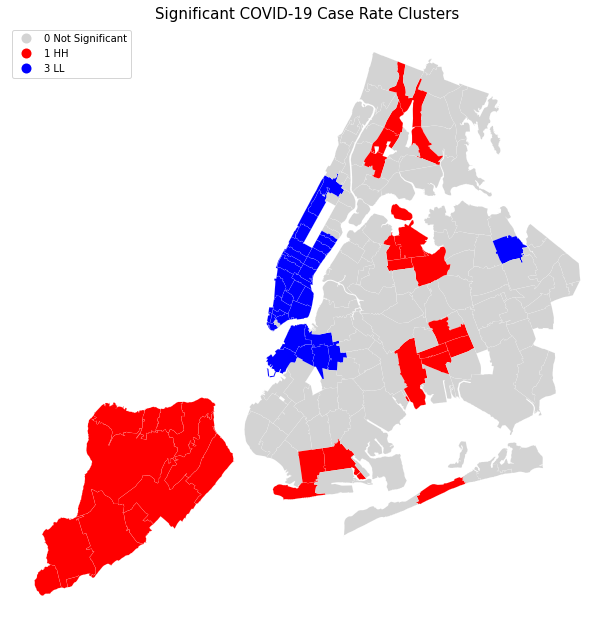

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(figsize=(11, 11))
# Make the axes accessible with single indexing
# axs = axs.flatten()

# ax = axs[0]
# q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
# labels = [q_labels[i-1] for i in lisa_cr.q]
# hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
# cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
#         k=2, cmap=hmap, linewidth=0.1, ax=ax, \
#         edgecolor='white', legend=True, legend_kwds={"loc": 2})

# ax.set_axis_off()
# ax.set_title('COVID-19 Case Rate Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})

sig = 1 * (lisa_cr.p_sim < 0.05)



ax = axs
hotspot = 1 * (sig * lisa_cr.q==1)
coldspot = 3 * (sig * lisa_cr.q==3)
doughnut = 2 * (sig * lisa_cr.q==2)
diamond = 4 * (sig * lisa_cr.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 Not Significant', '1 HH', '2 LH', '3 LL', '4 HL']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgray', 'red', 'blue'])


cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={"loc": 2})

ax.set_axis_off()
ax.set_title('Significant COVID-19 Case Rate Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})


plt.show()

# COVID-19 DEATH RATE LISA CLUSTERS

In [ ]:
lisa_dr = Moran_Local(cr_gdf['COVID_DEATH_RATE'], w)


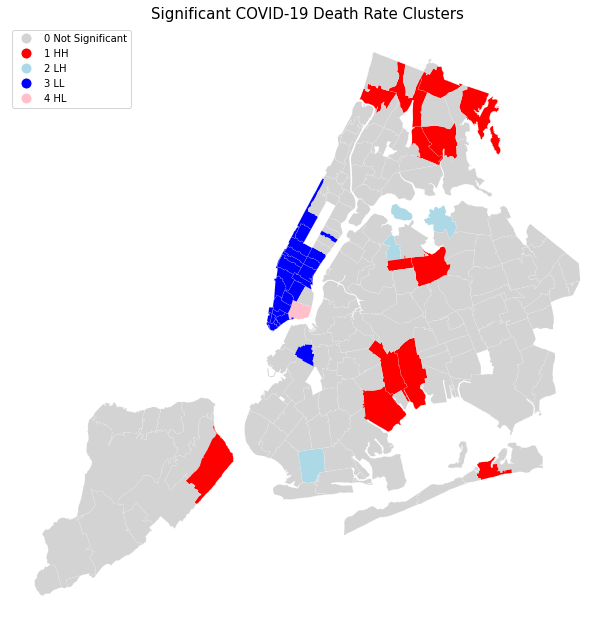

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(figsize=(11, 11))
# Make the axes accessible with single indexing
# axs = axs.flatten()

# ax = axs[0]
# q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
# labels = [q_labels[i-1] for i in lisa_dr.q]
# hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
# cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
#         k=2, cmap=hmap, linewidth=0.1, ax=ax, \
#         edgecolor='white', legend=True, legend_kwds={"loc": 2})

# ax.set_axis_off()
# ax.set_title('COVID-19 Death Rate Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})

sig = 1 * (lisa_dr.p_sim < 0.05)



ax = axs
hotspot = 1 * (sig * lisa_dr.q==1)
coldspot = 3 * (sig * lisa_dr.q==3)
doughnut = 2 * (sig * lisa_dr.q==2)
diamond = 4 * (sig * lisa_dr.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 Not Significant', '1 HH', '2 LH', '3 LL', '4 HL']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue', 'pink'])


cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={"loc": 2})

ax.set_axis_off()
ax.set_title('Significant COVID-19 Death Rate Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})


plt.show()

In [ ]:
# counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
# counts

In [ ]:
# sig = 1 * (lisa.p_sim < 0.05)
# cr_gdf['covdr-p-sim'] = lisa.p_sim
# cr_gdf['covdr-sig'] = sig
# cr_gdf[['modzcta', 'covdr-sig','covdr-p-sim']].head()

In [ ]:
# cr_gdf[['modzcta', 'covdr-sig','covdr-p-sim']].tail()


# RESTAURANT LISA CLUSTERS

In [ ]:
#OPEN RESTAURANT COUNT LISA CLUSTEERS
lisa_opnr = Moran_Local(cr_gdf['open_restaurant_count'], w)


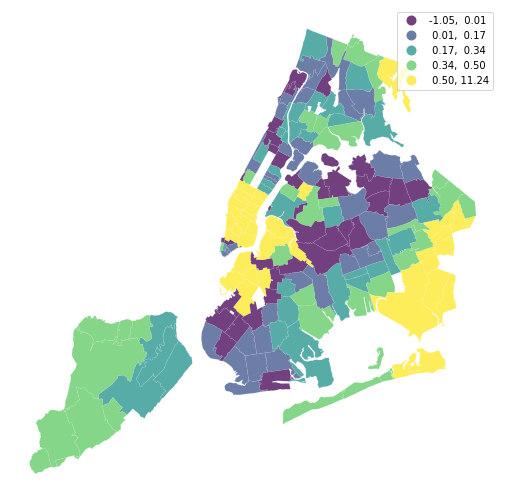

In [ ]:
f, ax = plt.subplots(1, figsize=(9,9))
cr_gdf['opr-Is'] = lisa_opnr.Is
cr_gdf.plot(column='opr-Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ax.set_axis_off()

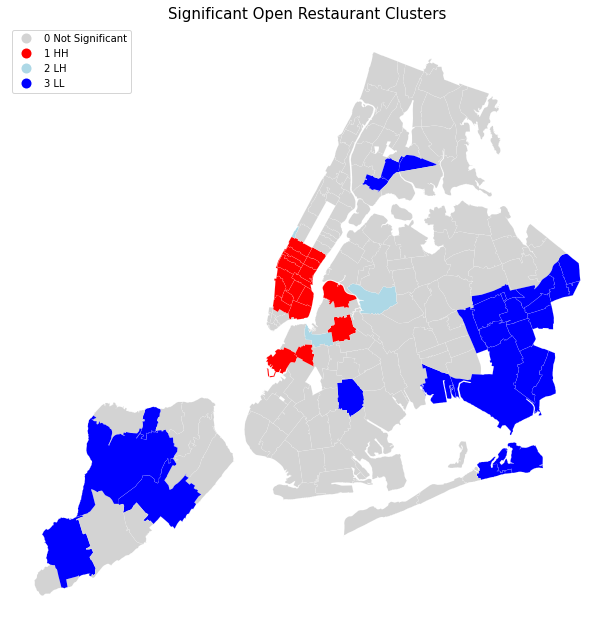

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(figsize=(11,11))
# Make the axes accessible with single indexing
# axs = axs.flatten()

# ax = axs[0]
# q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
# labels = [q_labels[i-1] for i in lisa_opnr.q]
# hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
# cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
#         k=2, cmap=hmap, linewidth=0.1, ax=ax, \
#         edgecolor='white', legend=True, legend_kwds={"loc": 2})

# ax.set_axis_off()
# ax.set_title('Open Restaurant Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})

sig = 1 * (lisa_opnr.p_sim < 0.05)



ax = axs
hotspot = 1 * (sig * lisa_opnr.q==1)
coldspot = 3 * (sig * lisa_opnr.q==3)
doughnut = 2 * (sig * lisa_opnr.q==2)
diamond = 4 * (sig * lisa_opnr.q==4)
spots = hotspot + coldspot + doughnut + diamond
# spots
spot_labels = [  '0 Not Significant', '1 HH', '2 LH', '3 LL', '4 HL']
labels = [spot_labels[i] for i in spots]
# labels
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue'])


cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={"loc": 2})

ax.set_axis_off()
ax.set_title('Significant Open Restaurant Clusters', fontdict={'fontsize': '15', 'fontweight' : '3'})


plt.show()



# POPULATION LISA CLUSTERS



In [ ]:
lisa_p = Moran_Local(cr_gdf['POP_DENOMINATOR'], w)


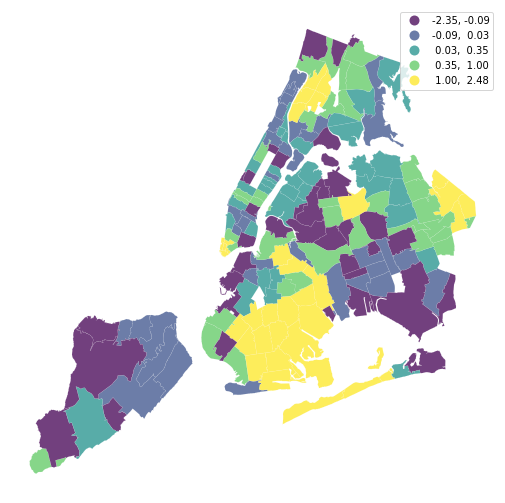

In [ ]:
f, ax = plt.subplots(1, figsize=(9,9))
cr_gdf['opr-Is'] = lisa_p.Is
cr_gdf.plot(column='opr-Is', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
ax.set_axis_off()

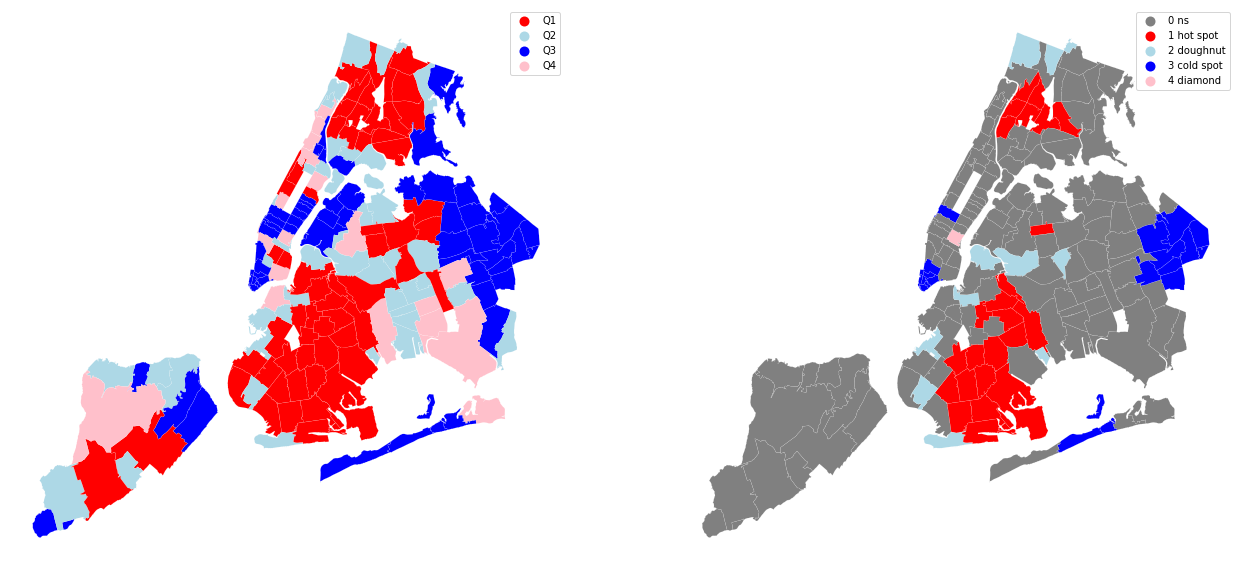

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(22, 22))
# Make the axes accessible with single indexing
# axs = axs.flatten()

ax = axs[0]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa_p.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

# ax.set_aspect('equal')
ax.set_axis_off()

sig = 1 * (lisa_p.p_sim < 0.05)



ax = axs[1]
hotspot = 1 * (sig * lisa_p.q==1)
coldspot = 3 * (sig * lisa_p.q==3)
doughnut = 2 * (sig * lisa_p.q==2)
diamond = 4 * (sig * lisa_p.q==4)
spots = hotspot + coldspot + doughnut + diamond
# spots
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
# labels
hmap = colors.ListedColormap([ 'grey', 'red', 'lightblue', 'blue', 'pink'])


cr_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

# ax.set_aspect('equal')
ax.set_axis_off()


# plt.show()